## Notebook  : Compute correlation and kinetic energy spectra using drifters data

### Description : 
In this notebook we compute correlation function and kinetic energy spectra using the drifters trajectories from our simulations output.
A decomposition of the time series in overlapping time windows is done. The total time period used, T is decomposed in time windows (segments) overlapping by usually 50%. The correlation or spectrum computation is done on each segment.

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima


import crocosi.postp as pp
from crocosi.jet import set_relevant_time

import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.0.75:48622 Dashboard: http://10.148.0.75:8787/status,Cluster Workers: 36 Cores: 36 Memory: 154.44 GB


---

## load data

In [5]:
#root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
root_path = '/home/c11-data/Test_aponte/jetn/old/'

run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'
#run = 'jet_cfg1_wp6_m2_4km_500a1000j/'
L=1026 # corresponds to the x period 

In [6]:
dr = cdr.drifter_dataframe(root_path+run,parquet=False,tdir_max=2,persist=False)

#### Tests

In [8]:
out = dr.df.groupby(['id']).mean()#.compute()
out
#Pas de problème pour juste une moyenne sur chaque trajectoire
y_bins = np.arange(500,2750,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
out['y_cut'] = out['y'].map_partitions(pd.cut, bins=y_bins)
# inspect df_chunked
out

,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y,y_cut
npartitions=1,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
umean = out.groupby(['y_cut']).mean().compute()

In [10]:
umean

,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
y_cut,,,,,,,,,,,,,
"(500, 550]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(550, 600]",1747.040785,86.487772,145.255900,50.0,0.623721,24.579771,0.005714,-0.000959,1.190110e-07,-3.100126e-08,6.972602,345.951090,581.023601
"(600, 650]",1721.466450,132.653359,157.217077,50.0,0.620586,24.579814,0.000700,-0.000087,1.125440e-07,-2.469060e-08,6.943303,530.613435,628.868308
"(650, 700]",1707.613551,135.153030,168.600072,50.0,0.620190,24.580015,-0.004470,0.000211,1.134951e-07,-2.398101e-08,6.930147,540.612119,674.400288
"(700, 750]",1720.049010,126.752919,181.861223,50.0,0.626193,24.580881,-0.010300,0.000149,1.091623e-07,-2.583330e-08,6.986907,507.011678,727.444891
"(750, 800]",1730.709865,133.389523,193.377277,50.0,0.627059,24.581082,-0.014751,-0.000597,1.076800e-07,-1.818260e-08,6.999072,533.558091,773.509106
"(800, 850]",1711.508604,135.898593,205.624250,50.0,0.632377,24.580041,-0.007467,-0.001296,1.074678e-07,-2.054782e-08,7.055695,543.594373,822.497002
"(850, 900]",1700.451153,120.348908,218.520630,50.0,0.633766,24.576959,0.013686,-0.000456,1.364246e-07,-3.229782e-08,7.068472,481.395631,874.082521
"(900, 950]",1697.846071,131.158326,231.051668,50.0,0.619174,24.566117,0.040047,-0.002897,1.735589e-07,-5.203547e-08,6.919591,524.633305,924.206671


In [69]:
def time_window_processing(df, myfun, columns):#, T, N, L, overlap=0.5, **myfun_kwargs):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        L: int
            Maximum x (used in mean_position)
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    tmin, tmax = p.index[0], p.index[-1]
    x, y = cdr.mean_position(p, L)
    myfun_out = np.cumsum(*[p[c] for c in columns]).values
    index = ['x','y']+['id']+['diag']#+list(myfun_out.index) 
    out = pd.DataFrame(np.vstack([np.ones(df.id.shape)*x,np.ones(df.id.shape)*y,df.id,myfun_out]).T,#+list(myfun_out)],
                            columns = index,
                            index = p.index)#[t+T/2.])
    # need to create an empty dataframe, in case the loop below is empty
#    myfun_out = myfun(*[None for c in columns], N, **myfun_kwargs) # get index from fake output
#    index = ['x','y']+['id']+list(myfun_out.index)
#    out = [pd.DataFrame({_:[] for _ in index})]
#    t=tmin
#    while t+T<tmax:
        #
#        _p = p.loc[t:t+T]
        # compute average position
#        x, y = mean_position(_p, L)
        # apply myfun
#        myfun_out = myfun(*[_p[c] for c in columns], N, **myfun_kwargs)
        # combine with mean position and time
#        _out = pd.DataFrame([[x, y]+[df.id.unique()[0]]+list(myfun_out)],
#                            columns = index,
#                            index = [t+T/2.])
#        out.append(_out)
#        t+=T*(1-overlap)
    return out#pd.concat(out)

In [41]:
x,y = cdr.mean_position(df.sort_values('time'),L)

In [68]:
np.vstack([np.ones(df.id.shape)*x,np.ones(df.id.shape)*y,df.id,np.cumsum(*[df[c] for c in ['u']]).values])

array([[ 2.91185275e+02,  2.91185275e+02,  2.91185275e+02, ...,
         2.91185275e+02,  2.91185275e+02,  2.91185275e+02],
       [ 1.93652186e+03,  1.93652186e+03,  1.93652186e+03, ...,
         1.93652186e+03,  1.93652186e+03,  1.93652186e+03],
       [ 2.25000000e+02,  2.25000000e+02,  2.25000000e+02, ...,
         2.25000000e+02,  2.25000000e+02,  2.25000000e+02],
       [-2.33660340e-01, -4.53109580e-01, -6.57321180e-01, ...,
         2.45937358e+03,  2.45914467e+03,  2.45891430e+03]])

In [65]:
pd.Series([x,y]).shape

(2,)

In [34]:
pd.DataFrame(np.vstack([np.cumsum(df.u).values,df.id]).T,
            columns = ['cumsum']+['id'],
            index = list(df.time.values))

,cumsum,id
1803.4236,-0.233660,225.0
1803.4306,-0.453110,225.0
1803.4375,-0.657321,225.0
1803.4444,-0.845236,225.0
1803.4514,-1.015773,225.0
...,...,...
1799.7500,2459.821743,225.0
1799.7569,2459.599700,225.0
1799.7639,2459.373582,225.0
1799.7708,2459.144671,225.0


In [70]:
out = time_window_processing(df,np.mean, ['u'])#, T, int(T/dt/2),L,dt=dt)
out

,x,y,id,diag
time,,,,
1500.0069,291.185275,1936.521857,225.0,0.213272
1500.0139,291.185275,1936.521857,225.0,0.426477
1500.0208,291.185275,1936.521857,225.0,0.639638
1500.0278,291.185275,1936.521857,225.0,0.852775
1500.0347,291.185275,1936.521857,225.0,1.065908
...,...,...,...,...
1999.9722,291.185275,1936.521857,225.0,2458.341456
1999.9792,291.185275,1936.521857,225.0,2458.515980
1999.9861,291.185275,1936.521857,225.0,2458.669855


In [71]:
out = dr.df.groupby(['id']).apply(time_window_processing,np.mean,['u'])#,T, int(T/dt/2),L,dt=dt)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [72]:
out

,x,y,id,diag
npartitions=752,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [73]:
#out = (
#              out.map_partitions(
#                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
#                                      )
#              )
y_bins = np.arange(500,2750,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
out['y_cut'] = out['y'].map_partitions(pd.cut, bins=y_bins)
#df0 = df_chunked.get_partition(10).compute()
# inspect df_chunked
out

,x,y,id,diag,y_cut
npartitions=752,,,,,
,float64,float64,float64,float64,category[known]
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


### load one drifter time series for tests

In [13]:
df = dr.df.get_partition(10).groupby(['id']).get_group(225).compute()
#df.head()


10.000004444753099

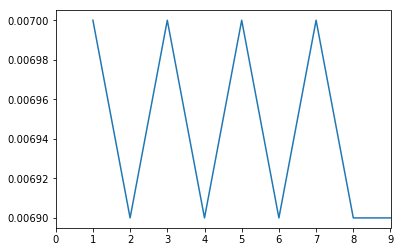

In [12]:
# illustrates variations in drifter time steps
df.sort_values('time').reset_index()['time'].diff().iloc[:10].plot()
df.sort_values('time').reset_index()['time'].diff().mean(axis=0)*24*60

---

## compute lagged autocorrelations

In [7]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50

In [9]:
# apply to one drifter
out = cdr.time_window_processing(df,cdr.correlate, ['u','u'], T, int(T/dt/2),L,detrend=True,dt=dt)
out

,x,y,id,0.0,0.006944444444444444,0.013888888888888888,0.020833333333333332,0.027777777777777776,0.034722222222222224,0.041666666666666664,...,9.944444444444445,9.951388888888888,9.958333333333332,9.965277777777777,9.972222222222221,9.979166666666666,9.98611111111111,9.993055555555555,trend_var_0,trend_var_1
1510.0069,1022.866620,1942.883560,225.0,43.205491,43.125509,42.954280,42.692924,42.343283,41.907904,41.390017,...,-5.462022,-5.470328,-5.478156,-5.485415,-5.491949,-5.497650,-5.502419,-5.506169,0.007652,0.007652
1520.0069,945.092028,1953.198851,225.0,36.538320,36.396708,35.974296,35.274565,34.303226,33.068217,31.579657,...,-12.777768,-13.347489,-13.812337,-14.168739,-14.413961,-14.546153,-14.564366,-14.468555,0.003712,0.003712
1530.0069,930.432523,1974.050691,225.0,45.580044,45.370140,44.849026,44.021400,42.894391,41.477562,39.782835,...,-2.182330,-1.843841,-1.503008,-1.162606,-0.825372,-0.494017,-0.171102,0.140883,0.007167,0.007167
1540.0069,1012.620378,1995.372894,225.0,51.454409,51.303687,50.871749,50.162463,49.182203,47.939769,46.446269,...,-2.897606,-3.115583,-3.348799,-3.595191,-3.853194,-4.121034,-4.396863,-4.678697,0.016541,0.016541
1550.0069,96.897904,1952.648187,225.0,42.964920,42.761136,42.246301,41.425886,40.308366,38.905004,37.229661,...,5.444066,5.283489,5.071302,4.808773,4.497559,4.139690,3.737552,3.293846,0.013409,0.013409
1560.0069,157.918396,1953.855647,225.0,32.459471,32.331668,31.967390,31.370317,30.546115,29.502510,28.249145,...,3.589252,3.037727,2.462302,1.866889,1.255532,0.632353,0.001562,-0.632533,0.007957,0.007957
1570.0069,239.144614,1976.728432,225.0,66.153829,65.912815,65.274606,64.245284,62.834607,61.055653,58.924860,...,-8.818737,-8.423115,-8.028421,-7.636738,-7.250095,-6.870514,-6.499954,-6.140369,0.008472,0.008472
1580.0069,288.544081,1884.823073,225.0,79.738989,79.435825,78.650481,77.390224,75.666786,73.496506,70.898394,...,9.518797,8.788772,7.895566,6.846479,5.650259,4.316868,2.857476,1.284367,0.001656,0.001656
1590.0069,349.592708,1808.957312,225.0,46.120812,45.926377,45.378628,44.483478,43.250668,41.693090,39.826851,...,6.196150,6.486693,6.729057,6.920519,7.058758,7.142096,7.168932,7.138877,0.048929,0.048929
1600.0069,548.147290,1662.938952,225.0,132.346634,131.966353,130.968955,129.364572,127.169832,124.407456,121.105310,...,19.861582,20.189627,20.450935,20.643728,20.766811,20.820073,20.803405,20.717381,0.092783,0.092783


### map the computation for each drifter

Here we compute the autocorrelation function of the zonal velocity and then compute the average value by binning the result in the y axis. This gives an average by y bins of the autocorrelation of u depending on the lag.

In [8]:
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
df_chunked = dr.df.groupby(['id']).apply(cdr.time_window_processing,
                                         cdr.correlate, ['v','u'], T, int(T/dt/2),L, detrend=True,dt=dt
                                        ).persist()
                                         #   meta=('x', 'f8'))
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# show one partition:
#df_chunked.get_partition(0).compute()

# bin along y and sum
y_bins = np.arange(500,2750,binsize)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
#df0 = df_chunked.get_partition(10).compute()
# inspect df_chunked
df_chunked


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [10]:
uu = df_chunked.groupby(['y_cut']).mean().compute()

In [11]:
#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

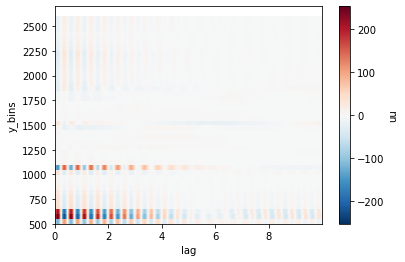

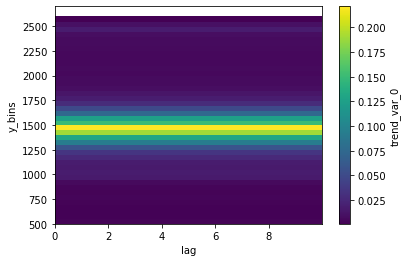

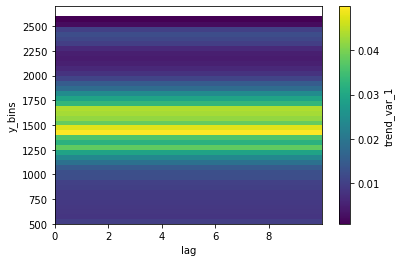

In [25]:
#Normalized autocorrelation 
(ds['uu']/ds['uu'].sel(lag=0.)).plot()
plt.figure()
ds['trend_var_0'].plot()
plt.figure()
ds['trend_var_1'].plot()

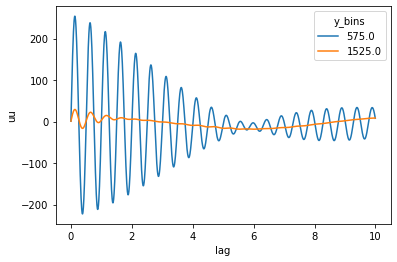

In [23]:
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=[1,20]).plot.line(x='lag')

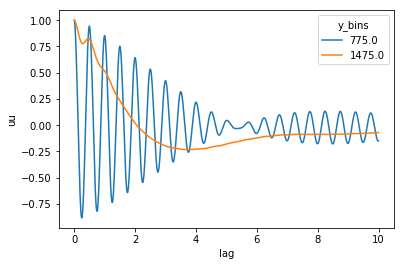

In [50]:
#Autocorrelation at 2 different y : 
#(ds['uu']/ds['uu'].sel(lag=0.)).sel(y_bins=600, method='nearest').plot.line(x='lag')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=[15,29]).plot.line(x='lag')

In [18]:
ds.attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'detrend':'linear'}

In [ ]:
#Save data in nc file
#name = 'uucorr_'+str(T)
#ds.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

### Same thing for the autocorrelation of v:
The shared steps will be summarized in a wrapper later to avoid repetition

In [63]:
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
df_chunked = dr.df.groupby(['id']).apply(cdr.time_window_processing,
                                         cdr.correlate, ['v','v'], T, int(T/dt/2),L, detrend=True,dt=dt
                                        )
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

# show one partition:
#df_chunked.get_partition(0).compute()

# bin along y and sum
y_bins = np.arange(0,2800,binsize)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
vv = df_chunked.groupby(['y_cut']).mean().compute()

# inspect df_chunked
df_chunked

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [65]:
#Converting pandas dataframe in xarray dataset:

ds = (pd.melt(vv.set_index(vv.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='lag')
      .rename(columns={'y_cut': 'y_bins', 'value': 'vv'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

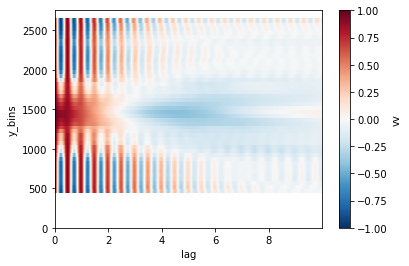

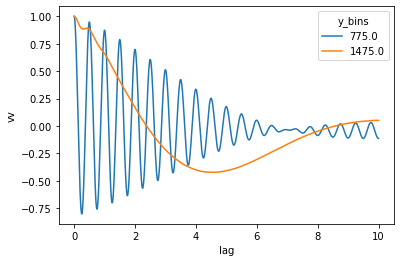

In [66]:
(ds['vv']/ds['vv'].sel(lag=0.)).plot()
plt.figure()
(ds['vv']/ds['vv'].sel(lag=0.)).isel(y_bins=[15,29]).plot.line(x='lag')

In [12]:
ds.attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'detrend':'linear'}

In [13]:
name = 'ubcorr_'+str(T)+'.nc'
ds.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

---
## compute spectra

In [9]:
from scipy import signal

def get_spectrum(v, N, dt=None, method='welch', detrend='linear', **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v: ndarray, pd.Series
            Time series, the index must be time if dt is not provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
        
        method: string
            Method that will be employed for spectral calculations.
            Default is 'welch'
            
        detrend: boolean, optional
            Turns detrending on or off. Default is 'linear'.

    See: 
        - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
        - https://krischer.github.io/mtspec/
        - http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    '''
    if v is None:
        _v = np.random.randn(N)
    else:
        _v = v.iloc[:N]
    if dt is None:
        dt = _v.reset_index()['index'].diff().mean()
    if detrend and not method=='welch':
        print('!!! Not implemented yet except for welch')    
    if method=='welch':
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(_v, fs=1/dt, axis=0, **dkwargs)
    elif method=='mtspec':
        lE, f = mtspec(data=_v, delta=dt, time_bandwidth=4.,
                       number_of_tapers=6, quadratic=True)
    elif method=='mt':
        dkwargs = {'NW': 2, 'sides': 'twosided', 
                   'adaptive': False, 'jackknife': False}
        dkwargs.update(kwargs)
        lf, E, nu = tsa.multi_taper_psd(_v, Fs=1/dt, **dkwargs)
        f = fftfreq(len(lf))*24.
        #print('Number of tapers = %d' %(nu[0]/2))
    return pd.Series(E, index=f)

In [10]:
dr.df['ui'] = dr.df.u+1j*dr.df.v

In [ ]:
# run computation over the whole dateset
T=20
dt = 10./60./24
df_chunked = apply_twin_processing(dr, get_spectrum, ['ui'], T, int(T/dt/2), dt=dt)

# bin sum
y_bins = np.arange(0,2800,30)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
Eu = df_chunked.groupby(['y_cut']).mean().compute()

ds_ft = (pd.melt(Eu.set_index(Eu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='frequency')
      .rename(columns={'y_cut': 'y_bins', 'value': 'Eu'})
      .set_index(['y_bins','frequency'])
      .to_xarray()
     )



/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


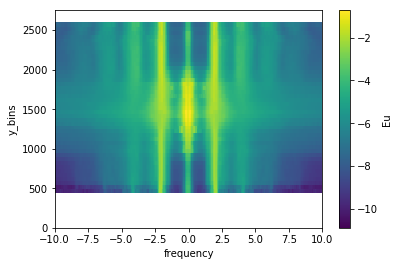

In [36]:
np.log10(ds.Eu).plot(x='frequency',y='y_bins',xlim=(-10,10))

Text(0,0.5,'Power spectral density')

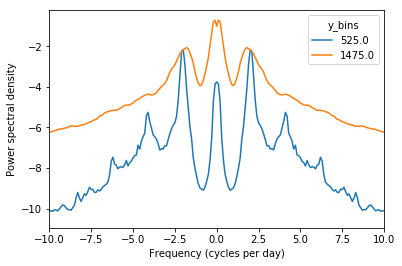

In [24]:
#Plot KE spectra for 2 y : 

np.log10(ds_ft.Eu.isel(y_bins=[10,29])).plot.line(x='frequency', xlim=(-10,10))
plt.xlabel('Frequency (cycles per day)');plt.ylabel('Power spectral density')

In [ ]:
#Save data in nc file
#name = 'Lspectra_'+str(T)+'.nc'
#ds_ft.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

---

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
